---
title: Overestimate feature importance in Random Forest
author: "Nguyễn Ngọc Bình"
---

> Tree-based models have a strong tendency to overestimate the importance of continuous numerical or high cardinality categorical features

Các mô hình dựa trên cây như `decision trees`, `random forests`, and `gradient boosting machines` (GBMs) có thể thể hiện sự thiên vị trong việc đánh giá quá cao tầm quan trọng của các các biến `continuous numerical` hoặc `high cardinality categorical features` trong một số trường hợp nhất định. Hiện tượng này thường được gọi là "variable bias" hay "variable inflation". Đây là lý do tại sao nó xảy ra:

1. **Chia nhị phân**: Các mô hình dựa trên cây đưa ra quyết định bằng cách chia tập dữ liệu thành các tập hợp con dựa trên giá trị của các đặc điểm. Trong quá trình đào tạo, họ liên tục phân chia dữ liệu dựa trên đặc điểm mang lại sự phân tách tốt nhất cho biến mục tiêu. Khi một biến continuous numerical có mối tương quan cao với mục tiêu, mô hình có thể sớm tạo ra sự phân chia dựa trên biến đó trong cây, khiến nó có vẻ quan trọng hơn thực tế.

2. **Hiệu ứng số lượng**: Các biến phân loại số lượng các nhóm nhiều (High cardinality categorical features) cũng có thể được ưa chuộng trong các phần tách vì chúng mang lại nhiều cơ hội cho mô hình phân chia dữ liệu. Điều này có thể khiến những đặc điểm này được coi là quan trọng hơn, ngay cả khi nhiều danh mục không thực sự mang tính thông tin.

3. **Tính ngẫu nhiên trong các khu rừng**: Trong trường hợp rừng ngẫu nhiên tổng hợp nhiều cây quyết định, tính ngẫu nhiên trong việc chọn một tập hợp con các đặc điểm ở mỗi lần phân chia có thể dẫn đến các cây khác nhau ưu tiên các biến phân loại có số lượng nhóm nhiều hoặc các biến liên tục. Sự ngẫu nhiên này đôi khi có thể phóng đại tầm quan trọng của những biến này.

4. **Hiệu ứng tỷ lệ**: Các biến số liên tục (Continuous numerical) có thể dễ bị ảnh hưởng hơn do sự khác biệt về tỷ lệ. Các biến có phạm vi số lớn hơn có thể có sự phân chia đáng kể hơn, điều này có thể thu hút sự chú ý của quá trình xây dựng cây. Ví dụ, các biến liên quan đến amount đơn vị triệu đồng, sẽ được tập trung nhiều hơn so với các biến như tuổi hay số năm làm việc.

Để giải quyết sự thiên vị hoặc đánh giá quá cao tầm quan trọng của tính năng, bạn có thể xem xét những điều sau:

- **Permutation Importance**: Sử dụng các kỹ thuật như Permutation Importance để đo lường tầm quan trọng của biến một cách chính xác hơn. Tầm quan trọng của hoán vị đánh giá mức độ giảm hiệu suất của mô hình (ví dụ: độ chính xác) khi các giá trị của một đối tượng được xáo trộn ngẫu nhiên, cung cấp thước đo mạnh mẽ hơn về tầm quan trọng của đối tượng.

- **Feature Engineering**: Thiết kế cẩn thận các features của bạn để giảm ảnh hưởng của high cardinality or continuous featues có thể bị tăng tầm quan trọng một cách giả tạo. Để giải quyết việc này thì sẽ cần các kỹ thuật binning.

- **Regularization**: Nếu bạn đang sử dụng máy tăng cường độ dốc, hãy cân nhắc sử dụng các kỹ thuật chính quy hóa (regularization) như max_deep, min_child_weight hoặc kiểm soát độ sâu của cây và hạn chế overfitting.

- **Kiến thức về lĩnh vực đang làm**: Tận dụng kiến thức về lĩnh vực của bạn để hiểu tầm quan trọng thực sự của các biến. Đôi khi, một số biến nhất định có thể thực sự quan trọng hơn và điều đó sẽ được phản ánh trong mô hình của bạn.

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# Load the German Credit dataset (assuming it's available in a CSV file)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
column_names = ["existing_account", "duration_month", "credit_history", "purpose", "credit_amount",
                "savings_account", "employment_since", "installment_rate", "personal_status_sex", "other_debtors",
                "present_residence", "property", "age", "other_installment_plans", "housing", "existing_credits",
                "job", "people_liable", "telephone", "foreign_worker", "credit_risk"]
df_raw = pd.read_csv(url, sep=" ", header=None, names=column_names)

In [3]:
df_raw.describe()

,duration_month,credit_amount,installment_rate,present_residence,age,existing_credits,people_liable,credit_risk
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,1.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


In [21]:
df_raw.infer_objects()

,existing_account,duration_month,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2


## Lựa chọn dữ liệu tính toán

Chọn các biến có các đặc điểm khác nhau như: biến dạng double, int, char

In [80]:
df = df_raw[['credit_risk','credit_amount', 'age', 'duration_month', 'credit_history', 'other_installment_plans']]

# Encode categorical variables (e.g., using one-hot encoding)
df = pd.get_dummies(df, columns=['credit_history', 'other_installment_plans'])

# Define the target variable and features
X = df.drop(columns=["credit_risk"])
y = df["credit_risk"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

## Tính feature importances với các biến đã lựa chọn ban đầu

In [75]:
# Compute feature importances using MDI
mdi_feature_importances = clf.feature_importances_

# Compute feature importances using permutation method
perm_importance = permutation_importance(clf, X_test, y_test, n_repeats=30, random_state=42)
perm_feature_importances = perm_importance.importances_mean

# Create DataFrames to display feature importances
mdi_importances_df = pd.DataFrame({"Feature": X.columns, "MDI Importance": mdi_feature_importances})
mdi_importances_df = mdi_importances_df.sort_values(by="MDI Importance", ascending=False)

perm_importances_df = pd.DataFrame({"Feature": X.columns, "Permutation Importance": perm_feature_importances})
perm_importances_df = perm_importances_df.sort_values(by="Permutation Importance", ascending=False)

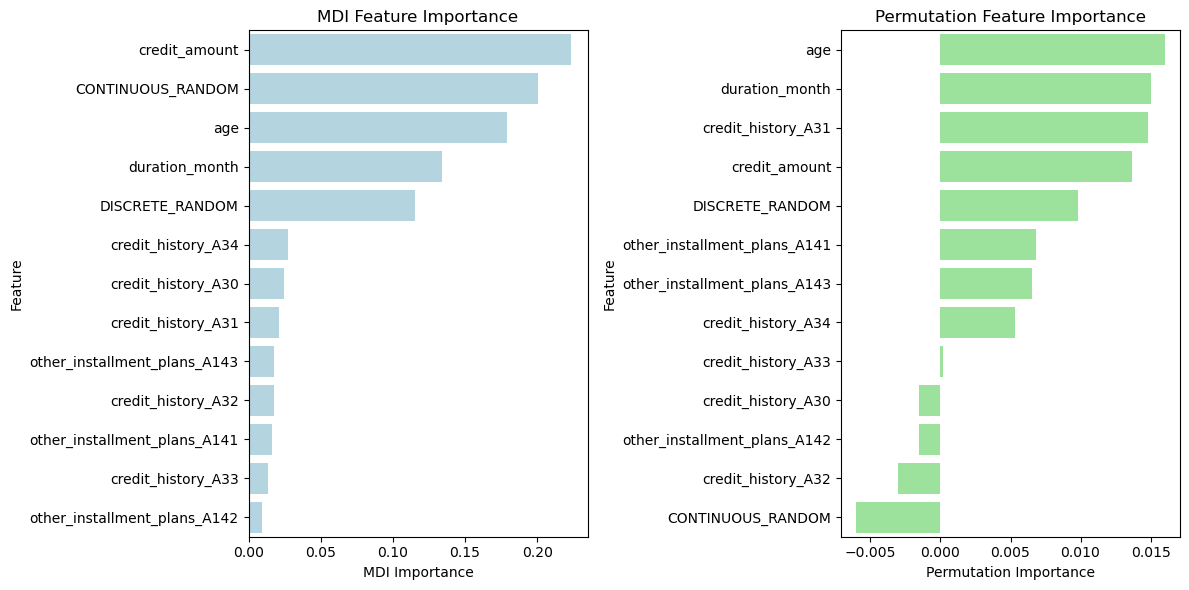

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create DataFrames to display feature importances from both methods...
# (As shown in the previous code)

# Create subplots for visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Visualize MDI feature importances
sns.barplot(x="MDI Importance", y="Feature", data=mdi_importances_df, ax=axes[0], color="lightblue")
axes[0].set_title("MDI Feature Importance")

# Visualize permutation feature importances
sns.barplot(x="Permutation Importance", y="Feature", data=perm_importances_df, ax=axes[1], color="lightgreen")
axes[1].set_title("Permutation Feature Importance")

plt.tight_layout()
plt.show()

## Thêm biến random để đánh giá

- Thêm 2 loại biến: 1 loại dạng CONTINUOUS variable, 1 loại DISCRETE variable  để đánh giá xem biến nào importance cao hơn và so với các biến khác trong dữ liệu thì như thế nào

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# Load and preprocess the German Credit dataset as before...

# Add two new random columns (Continuous_Random and Discrete_Random)
import numpy as np
np.random.seed(42)  # For reproducibility

# Create random continuous values
df['CONTINUOUS_RANDOM'] = np.random.uniform(0,200, size=len(df))

# Create random discrete values
df['DISCRETE_RANDOM'] = np.random.randint(0, 5, size=len(df))

# Create random discrete values
df['DISCRETE_RANDOM2'] = np.random.randint(0, 10, size=len(df))

# Define the target variable and features
X = df.drop(columns=["credit_risk"])
y = df["credit_risk"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Compute feature importances using MDI
mdi_feature_importances = clf.feature_importances_

# Compute feature importances using permutation method
perm_importance = permutation_importance(clf, X_test, y_test, n_repeats=30, random_state=42)
perm_feature_importances = perm_importance.importances_mean


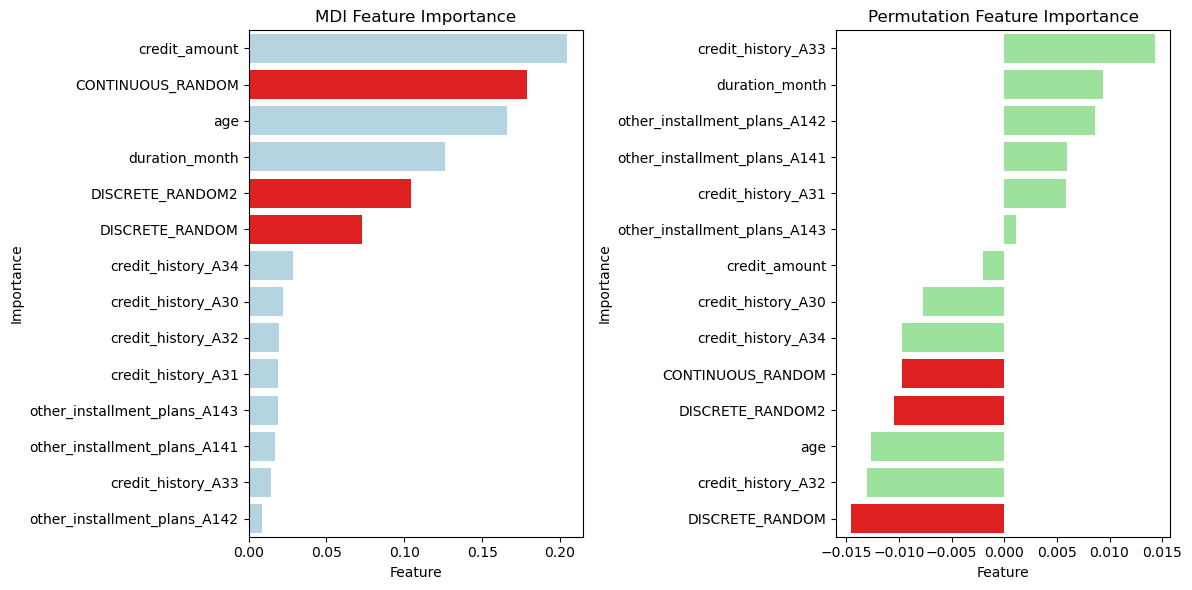

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def pImportanceWithHighlight(categories, values, highlight_categories, highlight_color='red', base_color='lightblue', title='Feature Importances'):          
    data = {'Category': categories,
            'Values': values}
    df = pd.DataFrame(data)   
    
    # Sort the DataFrame in increasing order of the 'Values' column
    df_sorted = df.sort_values(by='Values', ascending=False)
    df_sorted.reset_index(inplace=True, drop=True)    
    
     # Determine the positions (indices) of the highlighted categories
    highlight_indices = [idx for idx, cat in enumerate(df_sorted['Category']) if cat in highlight_categories]
    
    # Create a list of colors for each row, setting the highlight color for the specific rows
    colors = [base_color if idx not in highlight_indices else highlight_color for idx in range(len(df_sorted))]

    # Create a bar plot with the specified colors using Seaborn
    sns.barplot(x='Values', y='Category', data=df_sorted, palette=colors)

    # Add labels and a title
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title(title)

# Create subplots for visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Visualize MDI feature importances
plt.sca(axes[0])  # Set the current axes to the first subplot
pImportanceWithHighlight(X.columns, mdi_feature_importances, ['CONTINUOUS_RANDOM', 'DISCRETE_RANDOM', 'DISCRETE_RANDOM2'], title="MDI Feature Importance")

# Visualize permutation feature importances
plt.sca(axes[1])  # Set the current axes to the second subplot
pImportanceWithHighlight(X.columns, perm_feature_importances, ['CONTINUOUS_RANDOM', 'DISCRETE_RANDOM', 'DISCRETE_RANDOM2'], title="Permutation Feature Importance", base_color='lightgreen')

plt.tight_layout()
plt.show()